In [1]:
import pandas as pd
import numpy as np

import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

from glob import glob

from gensim.parsing.porter import PorterStemmer

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from IPython.display import clear_output

from utils import nltk_tag_to_wordnet_tag, lemmatize_sentence

from functools import reduce

import os 

import matplotlib.pyplot as plt
from nltk.tokenize import MWETokenizer

l = WordNetLemmatizer()

## Trained word2vector weight loader

In [2]:
from gensim.models import Word2Vec

'''
import the skip-gram model 
'''
EMB_DIM = 100
w2v = Word2Vec.load("word2vec_iter10_DIM100.model")
word_vectors = w2v.wv
embedding_matrix = word_vectors.vectors

In [3]:
#read the sheets of lists

xls_name = 'Labeling list_v4.xlsx'
sheet_names = pd.ExcelFile(xls_name).sheet_names

sheet_names

['Element list',
 'Defect',
 'Defect_Brick masonry',
 'Defect_Stone',
 'Defect_Concrete',
 'Defect_Metal and glass',
 'Defect_Glass',
 'Defect_Metal',
 'Attributes']

### Change Material Here

In [85]:
############## HERE #################
defect_sheet = 'Defect_Concrete'
############## HERE #################

'''
It will load defect words from the excel spreadsheet and also find matched reports in the next cell.

'''

'\nIt will load defect words from the excel spreadsheet and also find matched reports in the next cell.\n\n'

In [ ]:
'''
read word list and make a comprehensive list for all tenses and format.
'''

components = pd.read_excel(xls_name, sheet_name=sheet_names[0], header=None)
defects = pd.read_excel(xls_name, sheet_name=defect_sheet, header=None)
attributes = pd.read_excel(xls_name, sheet_name='Attributes', header=0)

#componnet and defect to lists
comp = components[0].tolist()
defe = defects[0].tolist()

#lower case for components and defects 
comp = [x.lower() for x in comp]
defe = [x.lower() for x in defe]

#attribute list
attr = np.array(attributes).flatten()
attr = pd.DataFrame(attr).dropna()[0].tolist()

#eliminate duplicates for comp, defect
comp = np.unique(comp)
defe = np.unique(defe)

#eliminate space in defect list
defe = [x[:-1] if x[-1] == ' ' else x for x in defe]

from pattern.en import pluralize, singularize

#make sure to consider plr anf single nouns
comp0 = comp
comp1 = [pluralize(x) for x in comp]
comp2 = [singularize(x) for x in comp]
comp = [[x,y,z] for x,y,z in zip(comp0.tolist(),comp1,comp2)]
comp = np.array(comp).flatten().tolist()

from pattern.en import conjugate

'''
process defect list
'''

#combining all formats and tenses of wordings together 
for i in range(2):
    try:
        dat = []
        dat.append(defe)
        for t in ['inf', '1sg', '3sg', '1sgp', 'pl', 'ppl', 'part', 'ppart']:
            dat.append(np.array(list(map(lambda x: conjugate(x, t), defe))))
    except:
        pass

dat = np.array(dat).T
defe = dat
defe = np.array(defe).flatten()
defe = defe.tolist()

#--> for multi wordings 
tokenizer = MWETokenizer([x.split(' ') for x in comp] + [x.split(' ') for x in defe] + [x.split(' ') for x in attr])

#tokenized component, defect, and attribute
comp = [tokenizer.tokenize(x.split()) for x in comp]
defe = [tokenizer.tokenize(x.split()) for x in defe]
attr = [tokenizer.tokenize(x.split()) for x in attr]

comp = [x[0] for x in comp]
defe = [x[0] for x in defe]
attr = [x[0] for x in attr]

### Read report ###

fpath = glob('0_Spellcheck_completed/*')

if defect_sheet == 'Defect_Concrete':
    file_path = [fpath[1]]
elif defect_sheet == 'Defect_Brick masonry':
    file_path = [fpath[3]]
elif defect_sheet == 'Defect_Stone':
    file_path = [fpath[6]]
elif defect_sheet == 'Defect_Metal and glass':
    file_path = [fpath[4]]
elif defect_sheet == 'Defect_Glass':
    file_path = [fpath[5]]
else:
    0

In [87]:
print(file_path)

['0_Spellcheck_completed/corrected_by_MS_API_Concrete.txt']


In [88]:
attr = [' floor' if '_floor' in x else x for x in attr]

## Read reports and tokenize into sentences

In [89]:
for f_ in file_path:
    txt = ''
    with open(f_, 'r', encoding='utf-8') as f:
        txt += ' ' + f.read()

#fix typos in text
txt = txt.replace('.', '. ')

txt = txt.replace('SWARMP', 'SWARMP ')
txt = txt.replace('/', ' or  ')
txt = txt.replace('.', ' . ')
txt = txt.replace("'", " ' ")
txt = txt.replace('"', ' " ')
txt = txt.replace('`', ' ` ')
txt = txt.replace('categorizedas', 'categorized as')
txt = txt.replace('rangedbetween', 'ranged between')
txt = txt.replace('wasobserved', 'was observed')

# sentence tokenization
sent_ = sent_tokenize(txt.lower())
sent_ = list(map(lambda x: x.replace('n/a', 'n/a '), sent_))
sent_ = list(map(lambda x: x.replace('/', ' / '), sent_))
sent_ = list(map(word_tokenize,sent_))

In [90]:
#Total number of sentences: Brick masonry 409097; 
len(sent_)

10040

## Tagging

In [91]:
#Initialize the tag matrix for sentence list
#for each word in the sentence, the initial tag was 'O'



sent_tag = []
for s in sent_:
    tag = []
    for w in s:
        tag.append('O')
    sent_tag.append(tag)

#tokenize sentences
sent_ = [tokenizer.tokenize(x) for x in sent_]

#combine sentence with sentence tag matrix
dict_sent = []
for s,t in zip(sent_,sent_tag):
    dict_sent.append([(x,y) for x,y in zip(s,t)])

# Different formats of the same component?
#Extract index of components in sentences
idx_comp = []
items = set(comp)
for x in sent_:
    found = [i for i,j in enumerate(x) if j in items]
    idx_comp.append(found)

# extract index of defects in sentences
idx_defe = []
items = set(defe)
for x in sent_:
    found = [i for i,j in enumerate(x) if j in items]
    idx_defe.append(found)
    
# extract index of attributes in sentences
idx_attr = []
items = set(attr)
for x in sent_:
    found = [i for i,j in enumerate(x) if j in items]
    idx_attr.append(found)

for st,idx_c in zip(sent_tag,idx_comp):
    for idx in idx_c:
        st[idx] = 'B-Component'

for st,idx_d in zip(sent_tag,idx_defe):
    for idx in idx_d:
        st[idx] = 'B-Defect'
        
for st,idx_d in zip(sent_tag,idx_attr):
    for idx in idx_d:
        st[idx] = 'B-Attr'

'''
parsing through sentences and tags, combined them together.
'''

dict_sent = []
for s,t in zip(sent_,sent_tag):
    dict_sent.append([(x,y) for x,y in zip(s,t)])


In [92]:
# Split B to B and I

'''
adding I tag to the inside wordings (multi words tokens)
'''
for cat in ['Component', 'Defect', 'Attr']:
    '10: max length of the multiword tokens'
    for k in range(10):
        for row in dict_sent:
            tup = [(i,x) for i,x in enumerate(row) if '_' in x[0] and x[1] == 'B-{}'.format(cat)]
            if len(tup) > 0:
                tup = tup[0]
                x = tup[1]
                del row[tup[0]]
                a = x[0].split('_')
                b = ['B-{}'.format(cat)] + ['I-{}'.format(cat)]*(len(a)-1)
                insert_list = [(a_,b_) for a_,b_ in zip(a,b)]

                for j in range(len(insert_list)):
                    row.insert(j + tup[0], insert_list[j])

In [93]:
#numpy array 
dict_sent = [np.array(x) for x in dict_sent]

In [94]:
#NOT preprocessing 
#FOR analysis: generate input for the table
arr = np.vstack(dict_sent)

unique, counts = np.unique([x for x in arr if x[1] == 'B-Defect'], return_counts=True)

df = pd.DataFrame(np.asarray((unique, counts)).T)
df[1] = df[1].astype(int)

df.sort_values(by=1,ascending=False)[:30]
#Output labeled defects in various forms and the frequency? 
#Some of the output words are not in the input list. Is this because the labeling is based on lemmatized tokens 
#and the output are based on original text?

#Need to combine the ones that are indicating the same defect type and addup the frequency

np.asarray((unique, counts)).T

arr = np.hstack([t[:,1] for t in dict_sent])

In [95]:
O, I, B = 0, 0, 0
B_component, B_defect, B_attr = 0, 0, 0

for t in arr:
    if t == 'O':
        O += 1
    elif t == 'B-Component':
        B_component += 1
    elif t == 'B-Defect':
        B_defect += 1
    elif t == 'B-Attr':
        B_attr += 1
    elif t[0] == 'I':
        I += 1

In [96]:
# number of components, defects, attributes tokens
B_component, B_defect, B_attr, O

(3935, 564, 490, 68189)

In [16]:
"""
Brick masonry: (138206, 22244, 18546, 2570239)
Stone: (6909, 1346, 1063, 125619)
Concrete:(3935, 564, 490, 68189)
"""

'\nBrick masonry: (138206, 22244, 18546, 2570239)\n\n'

In [97]:
# select sentences having Component
s_component = []
for s in dict_sent:
    if 'B-Component' in s[:,1]:
        s_component.append(s)
        
s_defect = []
for s in dict_sent:
    if 'B-Defect' in s[:,1]:
        s_defect.append(s)
        
s_attributes = []
for s in dict_sent:
    if 'B-Attr' in s[:,1]:
        s_attributes.append(s)

In [98]:
s_ = []
for s in dict_sent:
    if 'B-Component' in s[:,1] or 'B-Defect' in s[:,1] or 'B-Attr' in s[:,1]:
        s_.append(s)

In [99]:
# Number of sentences that Component OR defect OR attributes in a sentence
len(s_)

2689

In [100]:
len(s_component), len(s_defect), len(s_attributes)

(2341, 446, 421)

In [21]:
#Brick masonry: 100501 sentences, (84487, 17181, 16134)
#Stone: 5403 sentences, (4385, 1023, 959)
#concrete:2689 sentences, (2341, 446, 421)

In [22]:
#Need numbers for unique component, defect, and attribute

In [23]:
#Save the tagged sentences with labels 
#Ignore the previous ones if the files are saved

In [101]:
import pickle

In [102]:
# Save tagged sentences 
# UNcomment this cell when saving tagging results
with open('dict_sent/{}_dict_sent.txt'.format(defect_sheet), 'wb') as f:
    pickle.dump(dict_sent,f)

In [103]:
#Reading the saved tagged files.
with open('dict_sent/{}_dict_sent.txt'.format(defect_sheet), 'rb') as f:
    dict_sent = pickle.load(f)

In [104]:
# Split B to B and I

for cat in ['Component', 'Defect', 'Attr']:
    for k in range(10):
        for row in dict_sent:
            tup = [(i,x) for i,x in enumerate(row) if '_' in x[0] and x[1] == 'B-{}'.format(cat)]
            if len(tup) > 0:
                tup = tup[0]
                x = tup[1]
                del row[tup[0]]
                a = x[0].split('_')
                b = ['B-{}'.format(cat)] + ['I-{}'.format(cat)]*(len(a)-1)
                insert_list = [(a_,b_) for a_,b_ in zip(a,b)]

                for j in range(len(insert_list)):
                    row.insert(j + tup[0], insert_list[j])

In [105]:
len(dict_sent)
#How many sentences we have for each facade type?

10040

In [29]:
#concrete: 10040 sentences
#brick masonry: 409097
#Stone: 18601

In [30]:
# dict_sent = dict_sent[:200000]

In [106]:
'''
Filter sentences that have related information
'''
s_related = []
for s in dict_sent:
    if 'B-Component' in s[:,1] or 'B-Defect' in s[:,1] or 'B-Attr' in s[:,1]:
        s_related.append(s)

In [107]:
print(len(s_related))

2689


In [ ]:
#concrete: 2689 sentences
#brick masonry: 100501
#Stone: 5403

# Data Split

In [67]:
from random import sample

In [68]:
#considering all format for components and defects?

from pattern.en import pluralize, singularize, conjugate

def plusing(comp):
    comp0 = comp
    comp1 = [pluralize(x) for x in comp]
    comp2 = [singularize(x) for x in comp]
    comp = [[x,y,z] for x,y,z in zip(comp0.tolist(),comp1,comp2)]
#     comp = np.array(comp).flatten().tolist()
    return comp

def conj(defe):
    for i in range(2):
        try:
            dat = []
            dat.append(defe)
            for t in ['inf', '1sg', '3sg', '1sgp', 'pl', 'ppl', 'part', 'ppart']:
                dat.append(np.array(list(map(lambda x: conjugate(x, t), defe))))
        except:
            pass
    return dat

In [35]:
#split exclusive sentence set. E.g., set1 include [crack, cracking, cracks] and set2 includes [spall, spalled, spalling]
#Need to mainten the 7:3 ratio.
#Randomly pick words from training/testing and test the ratio.
#SKIP THIS ONE
components = pd.read_excel(xls_name, sheet_name=sheet_names[0], header=None)
defects = pd.read_excel(xls_name, sheet_name=defect_sheet, header=None)
attributes = pd.read_excel(xls_name, sheet_name='Attributes', header=0)
comp = components[0].tolist()
defe = defects[0].tolist()
comp = [x.lower() for x in comp]
defe = [x.lower() for x in defe]
attr = np.array(attributes).flatten()
attr = pd.DataFrame(attr).dropna()[0].tolist()
#get number of unique components?
#get number of unique defects?
comp = np.unique(comp)
comp = plusing(comp)

In [36]:
'name \'conj\'is not defined'
defe = [x[:-1] if x[-1]==' ' else x for x in defe]
defe = np.unique(defe)
defe = conj(defe)

In [37]:
defe = np.array(defe).T

# T R A I N

In [69]:
import random

In [42]:
#SKIP
#For exlusive set trial
def dupw(rnd):
#     X_train_, X_test_, y_train_, y_test_ = train_test_split(sentences, ner_tags, test_size=.22222, random_state=rnd
#     A_sen = np.hstack(X_train)
#     A_tag = np.hstack(y_train)
#     B_sen = np.hstack(X_test)
#     B_tag = np.hstack(y_test)

    A_sen = np.hstack([x[:,0] for x in train_set])
    A_tag = np.hstack([x[:,1] for x in train_set])
    B_sen = np.hstack([x[:,0] for x in test_set])
    B_tag = np.hstack([x[:,1] for x in test_set])


    A_idx = [i for i,x in enumerate(A_tag) if x in ['B-Attr', 'B-Component', 'B-Defect']]
    B_idx = [i for i,x in enumerate(B_tag) if x in ['B-Attr', 'B-Component', 'B-Defect']]

    len(np.unique(A_sen[A_idx])), len(np.unique(B_sen[B_idx]))

    a = np.unique(A_sen[A_idx])
    b = np.unique(B_sen[B_idx])

    # Words in B but not in A
    dup_words = [x for x in b if x not in a]
    return dup_words,a,b

# Processing NLP

In [108]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [109]:
dict_sent = s_related

In [110]:
dict_sent = [x for x in dict_sent if len(x) > 10]

In [111]:
# sentences = [word_tokenize(lemmatize_sentence(' '.join(s))) for s in sent_]
#sentences dataset
sentences = [np.array(x)[:,0].tolist() for x in dict_sent]
#tags dataset
ner_tags = [np.array(x)[:,1].tolist() for x in dict_sent]

Sample max length : 81
Sample avg length : 20.689912


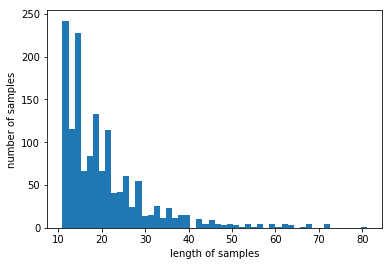

In [112]:
#Checking overview of the dataset
print('Sample max length : %d' % max(len(l) for l in sentences))
print('Sample avg length : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
#Vectorize the tokens
src_tokenizer = Tokenizer(oov_token='OOV') # define index 1 = OOV
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False)
tar_tokenizer.fit_on_texts(ner_tags)

In [114]:
#How many sentences/tokens used
vocab_size = len(src_tokenizer.word_index) + 1
# vocab_size = 4000
tag_size = len(tar_tokenizer.word_index) + 1
print('vocab size : {}'.format(vocab_size))
print('tag size : {}'.format(tag_size))

vocab size : 2250
tag size : 8


In [115]:
'tokenize sentences and tags?'
X_data = src_tokenizer.texts_to_sequences(sentences)
y_data = tar_tokenizer.texts_to_sequences(ner_tags)

In [ ]:
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [117]:
print(index_to_ner)

{1: 'O', 2: 'B-Component', 3: 'B-Defect', 4: 'B-Attr', 5: 'I-Component', 6: 'I-Attr', 7: 'I-Defect', 0: 'PAD'}


In [118]:
max_len = 70
X_data = pad_sequences(X_data, padding='post', maxlen=max_len)
y_data = pad_sequences(y_data, padding='post', maxlen=max_len)

In [119]:
x,y,x_,y_ = train_test_split(sentences, ner_tags, test_size=.2, random_state=777)

In [120]:
len(x_)

1181

In [121]:
O, I, B = 0, 0, 0
B_component, B_defect, B_attr = 0, 0, 0

for arr in x_:
    for t in arr:
        if t == 'O':
            O += 1
        elif t == 'B-Component':
            B_component += 1
        elif t == 'B-Defect':
            B_defect += 1
        elif t == 'B-Attr':
            B_attr += 1
        elif t[0] == 'I':
            I += 1

# number of components, defects, attributes tokens
B_component, B_defect, B_attr, O

(2054, 352, 302, 21563)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.2, random_state=777)

In [105]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [ ]:
print('Train sample size : {}'.format(X_train.shape))
print('Train sample label size : {}'.format(y_train.shape))
print('Test sample size : {}'.format(X_test.shape))
print('Test sample label size : {}'.format(y_test.shape))

Train sample size : (39944, 70)
Train sample label size : (39944, 70, 7)
Test sample size : (9986, 70)
Test sample label size : (9986, 70, 7)


'How about validation?'

In [107]:
'''
Brick masonry:
Train sample size : (80400, 70)
Train sample label size : (80400, 70, 7)
Test sample size : (20101, 70)
Test sample label size : (20101, 70, 7)
'''
'''
Concrete: 
Train sample size : (8032, 70)
Train sample label size : (8032, 70, 8)
Test sample size : (2008, 70)
Test sample label size : (2008, 70, 8)
'''

'\nConcrete: \nTrain sample size : (8032, 70)\nTrain sample label size : (8032, 70, 8)\nTest sample size : (2008, 70)\nTest sample label size : (2008, 70, 8)\n'

## Read Pretrained Word Embedding

In [108]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras.optimizers import Adam
from keras.callbacks import Callback

from seqeval.metrics import f1_score, classification_report
from keras.models import load_model
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy

In [ ]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # pred -> index_to_ner
      result = []
      for sequence in sequences: 
          tag = []
          for pred in sequence: # get pred from sequence
              pred_index = np.argmax(pred) # one hot encoding -> index
              tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD' -> 'O'
          result.append(tag)
      return result

    def on_epoch_end(self, epoch, logs={}):

      if self.use_char:
        X_test = self.validation_data[0]
        X_char_test = self.validation_data[1]
        y_test = self.validation_data[2]
        y_predicted = self.model.predict([X_test, X_char_test])

      else:
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_predicted = self.model.predict([X_test])

      pred_tags = self.sequences_to_tags(y_predicted)
      test_tags = self.sequences_to_tags(y_test)

      score = f1_score(pred_tags, test_tags)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(test_tags, pred_tags))

      if score > self.value:
        print('f1_score improved from %f to %f, saving model to best_model.h5'%(self.value, score))
        self.model.save('best_model.h5')
        self.value = score
      else:
        print('f1_score did not improve from %f'%(self.value))

In [ ]:
# different pre-trained model
pret_opt = ['Google', 'Glove', 'No pret', 'Pret report']
pret_model = pret_opt[int(input('0: Google\n1: glove\n2: no pretrained\n3: pretrained with report\n'))]
# pret_model = 'Pret report'

0: Google
1: glove
2: no pretrained
3: pretrained with report
2


In [ ]:
# Load pretrained model (Google w2v)
# Keep the Google model

if pret_model == 'Google':
    import gensim

    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

    print(word2vec_model.vectors.shape)

    embedding_matrix = np.zeros((vocab_size, 300))
    np.shape(embedding_matrix)

    def get_vector(word):
        if word in word2vec_model:
            return word2vec_model[word]
        else:
            return None

    for word, i in src_tokenizer.word_index.items(): 
        temp = get_vector(word) 
        if temp is not None: 
            embedding_matrix[i] = temp
else:
    print("You've not selected Google.")

You've not selected Google.


In [ ]:
# Load pretrained model (Glove)

if pret_model == 'Glove':
    import numpy as np
    embedding_dict = dict()
    f = open('glove.6B/glove.6B.100d.txt', encoding="utf8")
    
    for line in f:
        word_vector = line.split()
        word = word_vector[0]
        word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
        embedding_dict[word] = word_vector_arr
    f.close()
    
    embedding_matrix = np.zeros((vocab_size, 100))

    for word, i in src_tokenizer.word_index.items():
        temp = embedding_dict.get(word)
        if temp is not None:
            embedding_matrix[i] = temp

elif pret_model == 'Pret report':
    from gensim.models import Word2Vec
    import numpy as np

    EMB_DIM = 100
    w2v = Word2Vec.load("word2vec_iter10_DIM100.model")
    word_vectors = w2v.wv
    embedding_matrix = word_vectors.vectors
    print("You've selected facade report model.")

In [136]:
len(w2v.wv.vocab)

8393

In [137]:
vocab_length = len(embedding_matrix)

In [138]:
if pret_model == 'Google':
    embedding_layer = Embedding(vocab_length,
                                300,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=True, mask_zero=True)
elif pret_model == 'Glove':
    embedding_layer = Embedding(vocab_length,
                                100,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=True, mask_zero=True)
elif pret_model == 'Pret report':
    embedding_layer = Embedding(vocab_length,
                                100,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=True, mask_zero=True)

In [ ]:
# Bi-directional
model = Sequential()
if pret_model == 'No pret':
    model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len, mask_zero=True))
else:
    model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(TimeDistributed(Dense(50, activation='relu')))
crf = CRF(tag_size)
model.add(crf)

# model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
# model.compile(loss=crf.loss_function, optimizer=Adam(0.001), metrics=['accuracy'])
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

/home/bilab-ubuntu/.conda/envs/kpark/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/home/bilab-ubuntu/.conda/envs/kpark/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


In [140]:
'validation set: 0.2'
history = model.fit(X_train, y_train, batch_size=32, epochs=1,  validation_split = 0.2, callbacks=[F1score(use_char=False)])

Train on 31955 samples, validate on 7989 samples
Epoch 1/1
 2944/31955 [=>............................] - ETA: 2:55 - loss: 6.4926 - crf_viterbi_accuracy: 0.8625

KeyboardInterrupt: 

In [ ]:
epochs = range(1, len(history.history['val_loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from keras.models import load_model

In [ ]:
bilstm_crf_model = load_model('best_model.h5', custom_objects={'CRF':CRF,
                                                  'crf_loss':crf_loss,
                                                  'crf_viterbi_accuracy':crf_viterbi_accuracy})

In [ ]:
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [ ]:
#Model performance evaluation

f1score = F1score(use_char=False)

'On testing set (0.2?)'
y_predicted = bilstm_crf_model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)
print(classification_report(test_tags, pred_tags))

## Check manual sentence

In [ ]:
A_sen = np.hstack(X_train)
A_tag = np.hstack(y_train)
B_sen = np.hstack(X_test)
B_tag = np.hstack(y_test)

np.unique(A_tag)

A_idx = [i for i,x in enumerate(A_tag) if x in ['B-Attr', 'B-Component', 'B-Defect']]
B_idx = [i for i,x in enumerate(B_tag) if x in ['B-Attr', 'B-Component', 'B-Defect']]

len(np.unique(A_sen[A_idx])), len(np.unique(B_sen[B_idx]))

a = np.unique(A_sen[A_idx])
b = np.unique(B_sen[B_idx])

yo = [x for x in b if x not in a]

In [ ]:
new_sentence= X_test_[5208]

In [ ]:
new_encoded=[]
for w in new_sentence:
    try:
      new_encoded.append(word_to_index.get(w,1))
    except KeyError:
      new_encoded.append(word_to_index['OOV'])

In [ ]:
new_padded = pad_sequences([new_encoded], padding="post", value=0, maxlen=max_len)

p = bilstm_crf_model.predict(np.array([new_padded[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("word", "pred"))
print(30 * "=")
for w, pred in zip(new_sentence, p[0]):
    print("{:15}: {:5}".format(w, index_to_ner[pred]))